In [1]:
import o3fire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
#load complete cleaned data (missing value treatment)
firex_df_clean = pd.read_csv('../../data/gap_filled/firex_complete.csv', parse_dates=['timestamp'], index_col='timestamp')
wecan_df_clean = pd.read_csv('../../data/gap_filled/wecan_complete.csv', parse_dates=['timestamp'], index_col='timestamp')
arctas_df_clean = pd.read_csv('../../data/gap_filled/arctas_complete.csv', parse_dates=['timestamp'], index_col='timestamp')
atom_df_clean = pd.read_csv('../../data/gap_filled/atom_complete.csv', parse_dates=['timestamp'], index_col='timestamp')
dc3_60s_df_clean = pd.read_csv('../../data/gap_filled/dc3_complete.csv', parse_dates=['timestamp'], index_col='timestamp')

wecan_df_clean['altitude'] = wecan_df_clean['altitude']*1e3
arctas_df_clean['altitude'] = arctas_df_clean['altitude']*1e3
dc3_60s_df_clean['altitude'] = dc3_60s_df_clean['altitude']*1e3

In [3]:
df = pd.read_csv('../../data/processed/complete_data.csv', parse_dates=['timestamp'], index_col='timestamp')

/tmp/ipykernel_250992/4140673560.py:1: DtypeWarning: Columns (195) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/processed/complete_data.csv', parse_dates=['timestamp'], index_col='timestamp')


# Plot

### Figure S1

In [4]:
# concat clean dfs
full_clean_df = pd.concat([firex_df_clean, wecan_df_clean, arctas_df_clean, atom_df_clean, dc3_60s_df_clean], axis=0)

In [24]:
def visualize_stratospheric_influence(o3, h2o, alt, savefig=False):
    fig, ax = plt.subplots(dpi=300)
    fig.set_size_inches(7,4)
    p = ax.scatter((o3 / h2o), o3, alpha=0.2, c=alt)

    ax.vlines(0.003, 0, 1000, 'k', '--', alpha=0.4)
    ax.vlines(1, 0, 1000, 'k', '--', alpha=0.4)

    cbar = fig.colorbar(p,)
    cbar.set_label('Altitude (m)', fontsize=14)

    ax.set_xscale('log')
    ax.set_yscale('log')

    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    ax.set_ylabel(r'O$_3$ (ppb)', fontsize=14)
    ax.set_xlabel(r'$ O_3 / H_2O$  $(\frac{ppb}{ppm})$', fontsize=14)

    ax.set_title(r'Marine and Stratospheric Ozone Influence', fontsize=12)

    if savefig:
        plt.savefig('../../figures/supfig_01.pdf', dpi=100, bbox_inches='tight')

    return ax

In [25]:
# remove outliers that make the plot look weird in log space (we are removing them from the final dataset anyways)
tmp = full_clean_df[full_clean_df['O3']>5]

<AxesSubplot: title={'center': 'Marine and Stratospheric Ozone Influence'}, xlabel='$ O_3 / H_2O$  $(\\frac{ppb}{ppm})$', ylabel='O$_3$ (ppb)'>

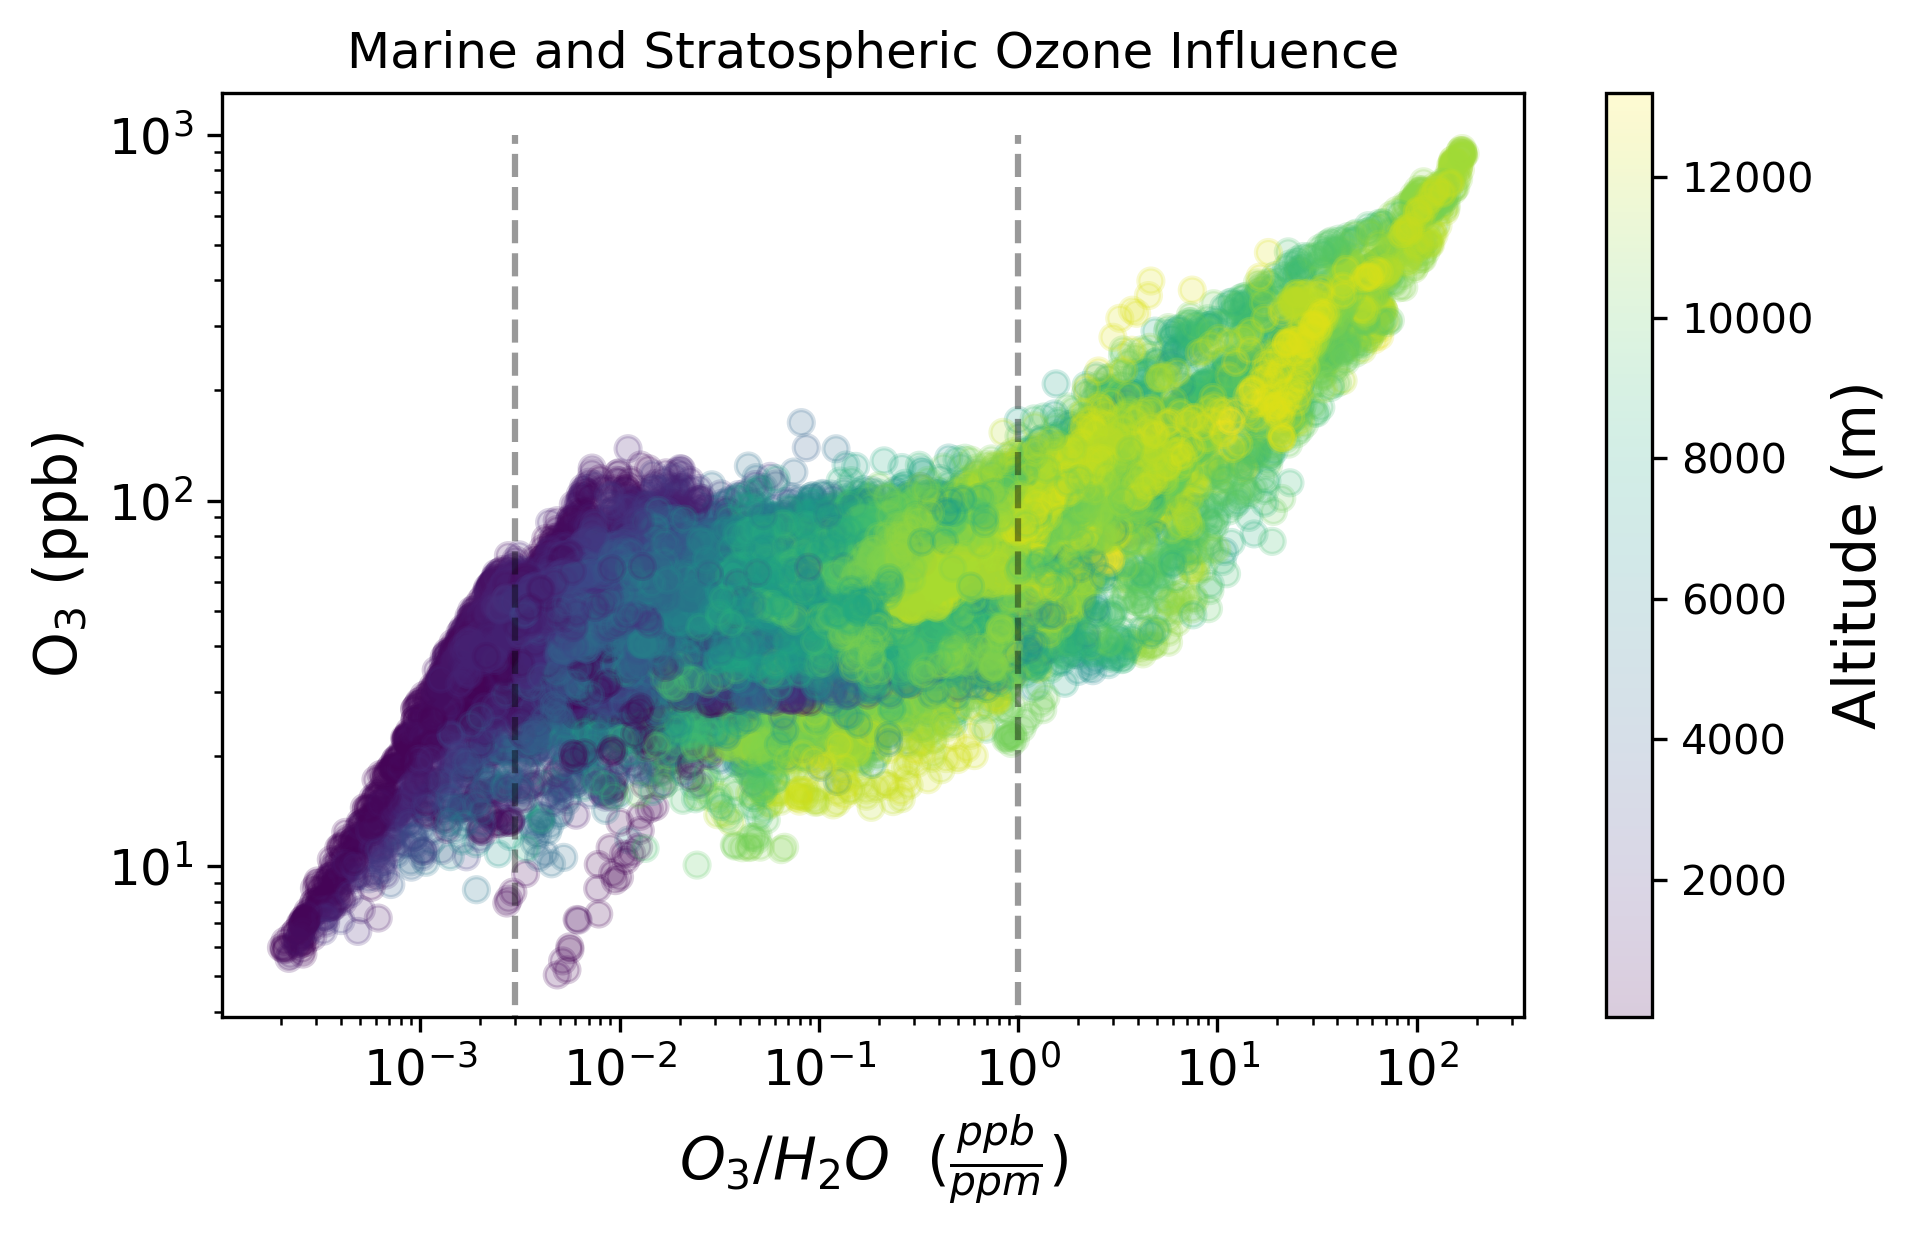

In [26]:
visualize_stratospheric_influence(tmp['O3'], tmp['H2O'], tmp['altitude'], savefig=True)

### Figure S2

In [18]:
#split up clean data -- 40th percentile of CO
clean_df = o3fire.baseline.split_clean(df)

In [19]:
# altitude dependent baseline
troposphere_alt_bins = np.array([0, 2, 4, 6, 8, 10, 12])*1000
troposphere_alt_ranges = troposphere_alt_bins[0:-1]

In [20]:
ft_tmp_atom = clean_df[clean_df['campaign']=='ATom'].copy(deep=True)
ft_tmp_other = clean_df[clean_df['campaign']!='ATom'].copy(deep=True)
ft_tmp_arctas = clean_df[((clean_df['lat'])>49)].copy(deep=True)
ft_tmp_atom['alt_range'] =  pd.cut(ft_tmp_atom['altitude'], troposphere_alt_bins)
ft_tmp_other['alt_range'] =  pd.cut(ft_tmp_other['altitude'], troposphere_alt_bins)
ft_tmp_arctas['alt_range'] =  pd.cut(ft_tmp_arctas['altitude'], troposphere_alt_bins)
other_count = ft_tmp_other.groupby('alt_range').count()
atom_count = ft_tmp_atom.groupby('alt_range').count()
arctas_count = ft_tmp_arctas.groupby('alt_range').count()

In [21]:
# subtract baseline
atom_trop_baseline, atom_enhancements_df = o3fire.baseline.subtract_baseline(df[df['campaign']=='ATom'], clean_df, method='altitude_dependent', baseline_percentile=0.25, remote=True)
arctas_trop_baseline, arctas_enhancements_df = o3fire.baseline.subtract_baseline((df[(df['campaign'] == 'ARCTAS')&(df['lat'] > 49)]), clean_df, method='altitude_dependent', baseline_percentile=0.25, arctic=True)
other_trop_baseline, other_enhancements_df = o3fire.baseline.subtract_baseline(df[(df['campaign']!='ATom')&(df['lat'] < 49)], clean_df, method='altitude_dependent', baseline_percentile=0.25,)

/net/fs09/d0/jpalmo/Projects/O3Fire/paper/o3fire/baseline.py:57: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trop_baseline = ft_tmp.groupby('alt_range').quantile(baseline_percentile)
/net/fs09/d0/jpalmo/Projects/O3Fire/paper/o3fire/baseline.py:57: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trop_baseline = ft_tmp.groupby('alt_range').quantile(baseline_percentile)
/net/fs09/d0/jpalmo/Projects/O3Fire/paper/o3fire/baseline.py:57: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeri

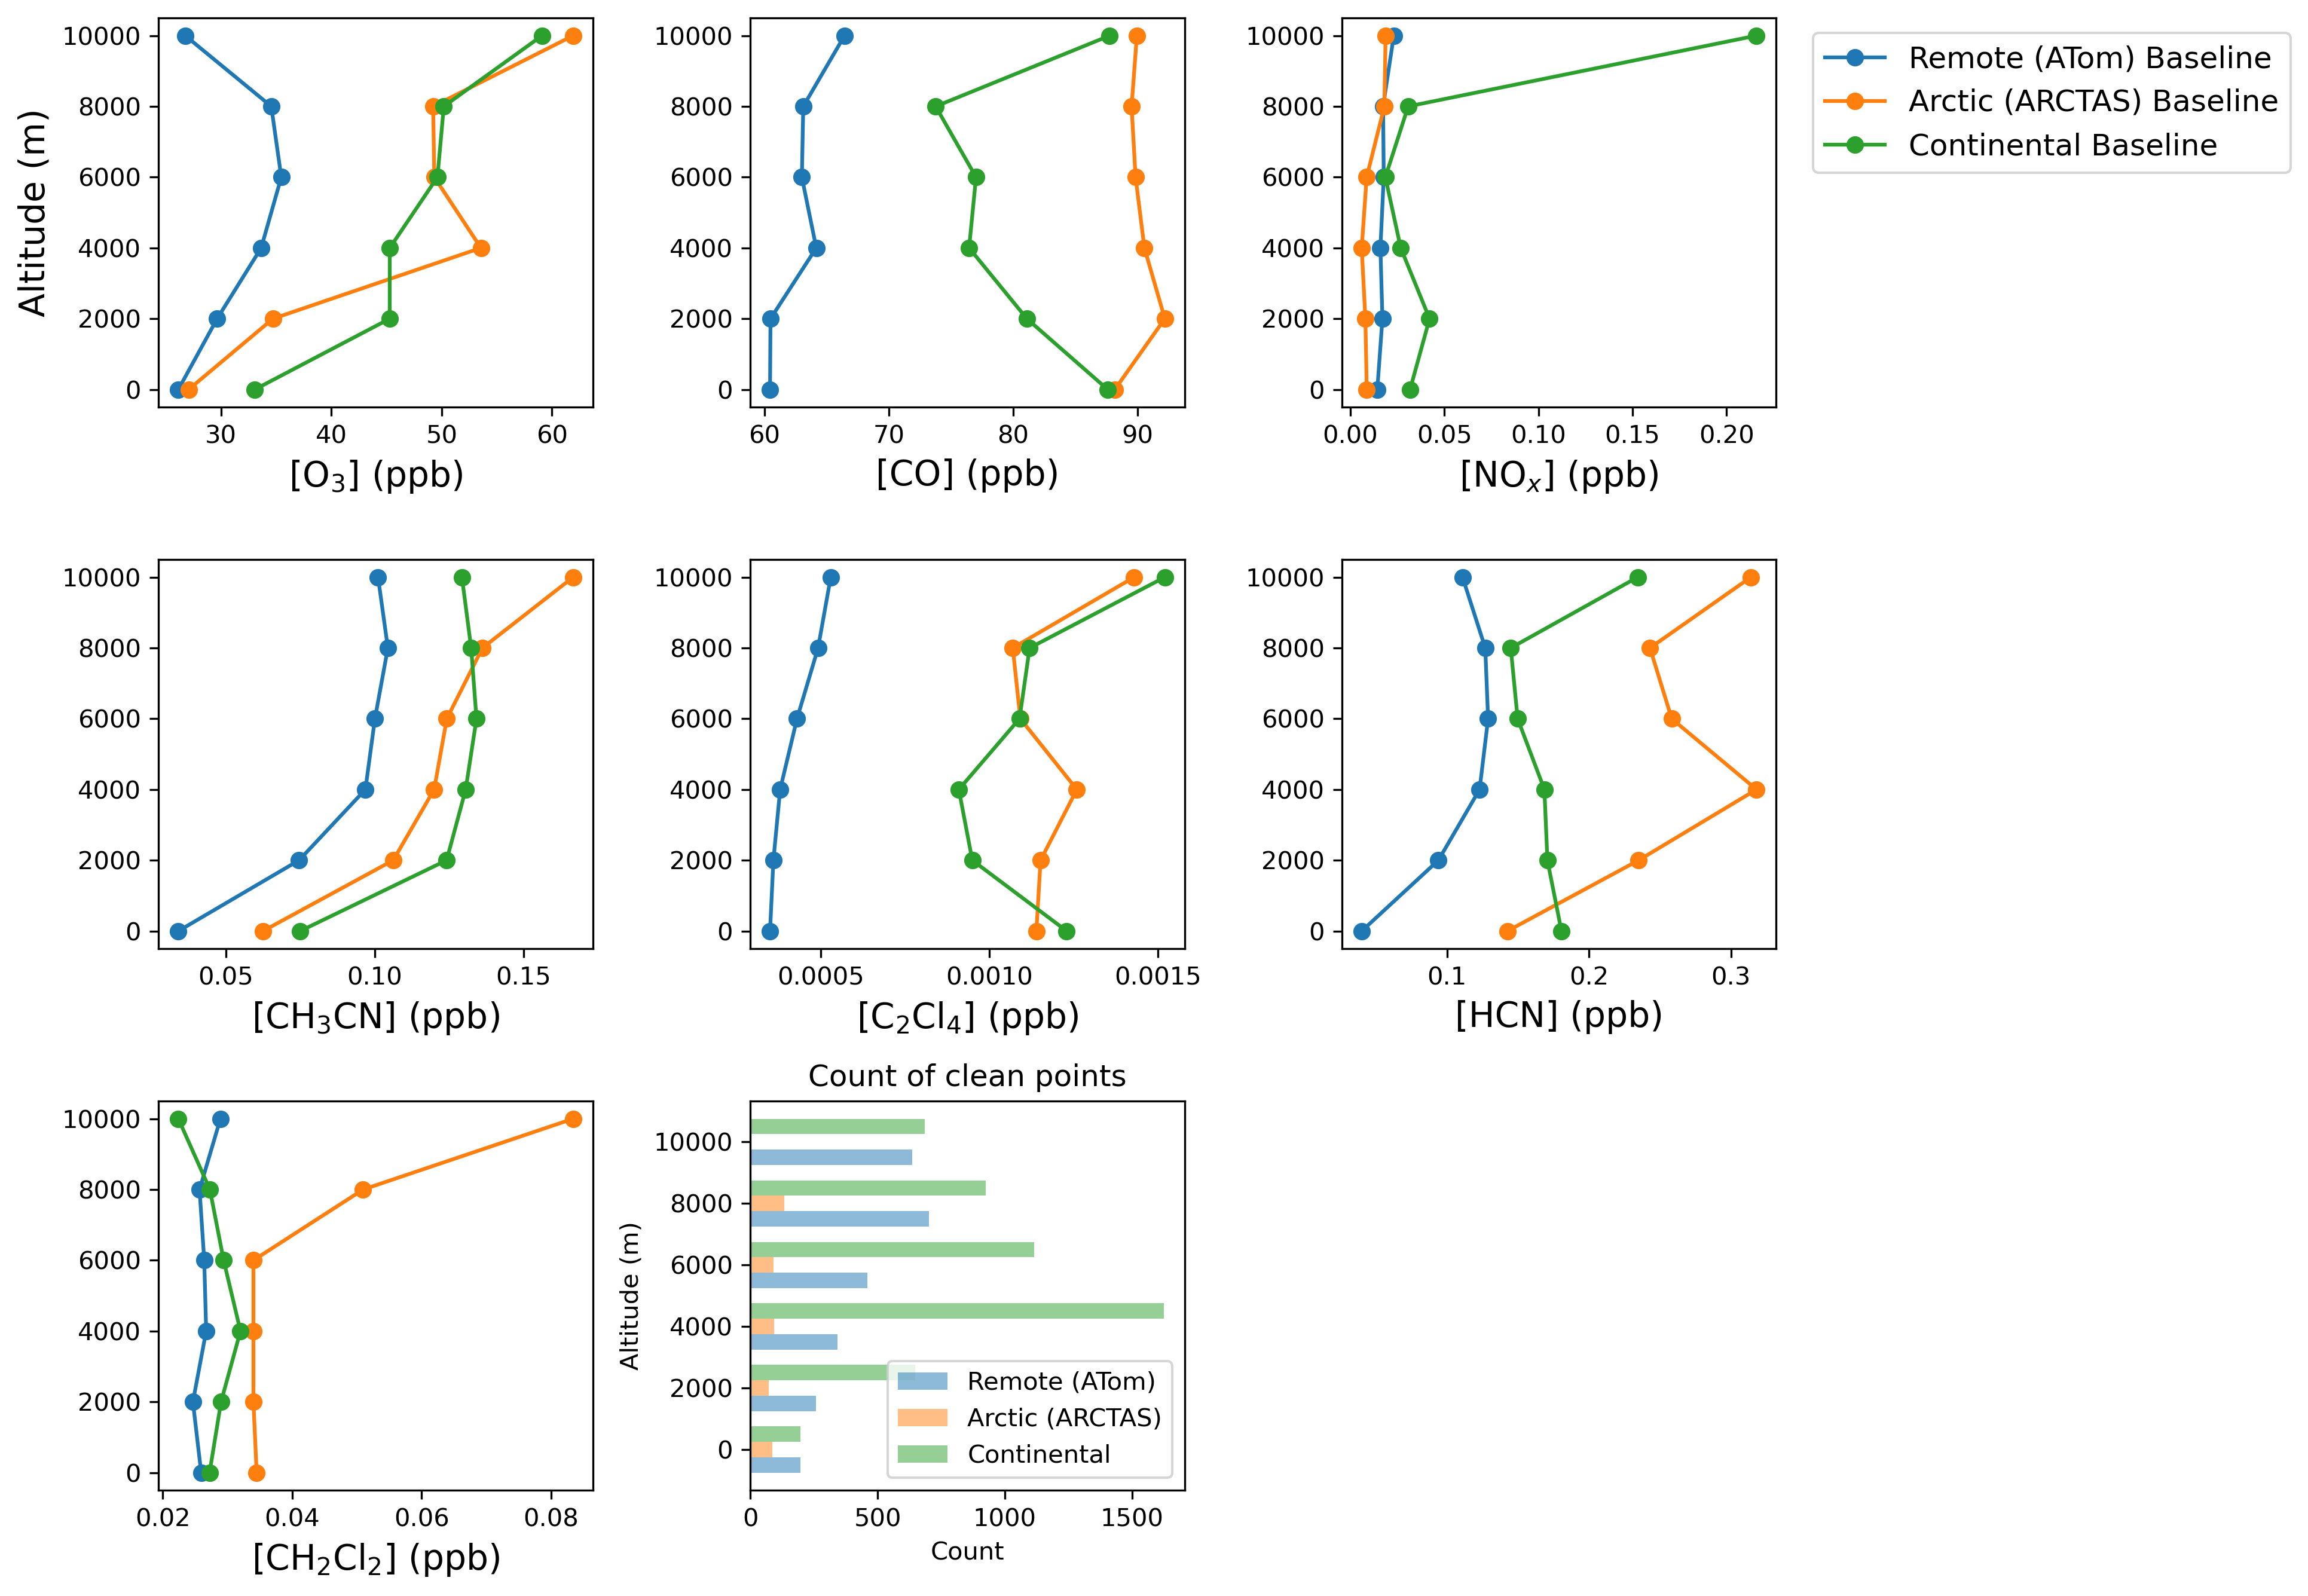

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(13,9), dpi=300)

axs = axs.flatten()
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axs

# O3 plot
ax1.errorbar(atom_trop_baseline['O3']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='ATom Baseline')
ax1.errorbar(arctas_trop_baseline['O3']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='ARCTAS Baseline') 
ax1.errorbar(other_trop_baseline['O3']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Continental Baseline')
ax1.set_xlabel(r"[O$_3$] (ppb)", fontsize=14)
ax1.set_ylabel(r"Altitude (m)", fontsize=14)

# CO plot 
ax2.errorbar(atom_trop_baseline['CO']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='ATom Baseline')
ax2.errorbar(arctas_trop_baseline['CO']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='ARCTAS Baseline')
ax2.errorbar(other_trop_baseline['CO']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Continental Baseline')
ax2.set_xlabel(r"[CO] (ppb)", fontsize=14)

# NOx plot
ax3.errorbar(atom_trop_baseline['NOx']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Remote (ATom) Baseline')
ax3.errorbar(arctas_trop_baseline['NOx']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Arctic (ARCTAS) Baseline')
ax3.errorbar(other_trop_baseline['NOx']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Continental Baseline')
ax3.set_xlabel(r"[NO$_x$] (ppb)", fontsize=14)

# CH3CN plot
ax4.errorbar(atom_trop_baseline['CH3CN']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='ATom Baseline')
ax4.errorbar(arctas_trop_baseline['CH3CN']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='ARCTAS Baseline')
ax4.errorbar(other_trop_baseline['CH3CN']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Continental Baseline')
ax4.set_xlabel(r"[CH$_3$CN] (ppb)", fontsize=14)

# C2Cl4 plot
ax5.errorbar(atom_trop_baseline['C2Cl4']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='ATom Baseline')
ax5.errorbar(arctas_trop_baseline['C2Cl4']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='ARCTAS Baseline')
ax5.errorbar(other_trop_baseline['C2Cl4']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Continental Baseline')
ax5.set_xlabel(r"[C$_2$Cl$_4$] (ppb)", fontsize=14)

# HCN plot
ax6.errorbar(atom_trop_baseline['HCN']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Remote (ATom) Baseline')
ax6.errorbar(arctas_trop_baseline['HCN']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Arctic (ARCTAS) Baseline')
ax6.errorbar(other_trop_baseline['HCN']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Continental Baseline')
ax6.set_xlabel(r"[HCN] (ppb)", fontsize=14)

# CH2Cl2 plot
ax7.errorbar(atom_trop_baseline['CH2Cl2']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='ATom Baseline')
ax7.errorbar(arctas_trop_baseline['CH2Cl2']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='ARCTAS Baseline')
ax7.errorbar(other_trop_baseline['CH2Cl2']/1000, troposphere_alt_ranges, xerr=None, fmt='o-', label='Continental Baseline')
ax7.set_xlabel(r"[CH$_2$Cl$_2$] (ppb)", fontsize=14)

# sideways barplot with the counts of each altitude range
ax8.barh(troposphere_alt_ranges-500, atom_count['lat'], height=500, alpha=0.5, label='Remote (ATom)')
ax8.barh(troposphere_alt_ranges, arctas_count['lat'], height=500, alpha=0.5, label='Arctic (ARCTAS)')
ax8.barh(troposphere_alt_ranges+500, other_count['lat'], height=500, alpha=0.5, label='Continental')
ax8.set_xlabel('Count')
ax8.set_ylabel('Altitude (m)')
ax8.set_title('Count of clean points')
ax8.legend()

ax9.remove()

# Add legend to last subplot
ax3.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('../../figures/supfig_02.pdf', dpi=300, bbox_inches='tight')